In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from carps.analysis.process_data import get_interpolated_performance_df, load_logs


def print_overview(df_trials: pd.DataFrame) -> None:
    print(df_trials.columns)
    print(df_trials["optimizer_id"].unique())
    print(df_trials["benchmark_id"].unique())
    print(df_trials["problem_id"].unique())
    print(df_trials["scenario"].unique())
    print("Number of seeds", df_trials["seed"].nunique())


rundir = "../runs"

df, df_cfg = load_logs(rundir=rundir)
print_overview(df)
perf = get_interpolated_performance_df(df)
perf_time = get_interpolated_performance_df(df, x_column="time_norm")


[14:30:06] INFO     Load logs from `../runs/logs.csv` and associated configs from               ]8;id=15291;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=857860;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#156\156]8;;\
                    ../runs/logs_cfg.csv. Preprocess logs.                                                         

/scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py:162: DtypeWarning: Columns (7,9,21,26,27,28,31,32,33,34,35,41,42,43,46,47,48,49,52,54,55,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(logs_fn)


[14:30:23] INFO     Processing raw logs. Normalize n_trials and costs. Calculate trajectory      ]8;id=760186;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=667226;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#66\66]8;;\
                    (incumbent cost).                                                                              

Index(['n_trials', 'n_function_calls', 'trial_info__config',
       'trial_info__instance', 'trial_info__seed', 'trial_info__budget',
       'trial_info__normalized_budget', 'trial_info__name',
       'trial_info__checkpoint', 'trial_value__cost', 'trial_value__time',
       'trial_value__virtual_time', 'trial_value__status',
       'trial_value__starttime', 'trial_value__endtime', 'seed',
       'benchmark_id', 'problem_id', 'optimizer_id', 'problem.model_id',
       'problem.dataset_id', 'problem.surrogates_dir', 'task.n_trials',
       'task.time_budget', 'task.n_workers', 'task.n_objectives',
       'task.objectives', 'task.is_multifidelity', 'task.fidelity_type',
       'task.min_budget', 'task.max_budget', 'task.has_constraints',
       'task.domain', 'task.objective_function_approximation',
       'task.has_virtual_time', 'task.deterministic', 'task.dimensions',
       'task.search_space_n_categoricals', 'task.search_space_n_ordinals',
       'task.search_space_n_integers', 'tas

[14:32:21] INFO     Create dataframe for neat plotting by aligning x-axis / interpolating       ]8;id=88845;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=856217;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#126\126]8;;\
                    budget.                                                                                        

[14:32:30] INFO     Create dataframe for neat plotting by aligning x-axis / interpolating       ]8;id=204950;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=714378;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#126\126]8;;\
                    budget.                                                                                        

--------------------------------------------------
blackbox
optimizer_id                         HEBO  RandomSearch  \
problem_id                                                
hpob/subset/5489/3011           -0.992715     -0.992715   
hpob/subset/5489/34             -0.711111     -0.711111   
hpob/subset/5489/3849           -0.683924     -0.683924   
hpob/subset/5489/3866           -0.807104     -0.807104   
hpob/subset/5489/50             -0.801794     -0.801794   
...                                   ...           ...   
yahpo/so/lcbench/189906/None   -83.024295    -87.963231   
yahpo/so/rbv2_glmnet/375/None   -0.960861     -0.960561   
yahpo/so/rbv2_glmnet/458/None   -0.998034     -0.996789   
yahpo/so/rbv2_rpart/14/None     -0.802151     -0.764013   
yahpo/so/rbv2_rpart/40499/None  -0.885329     -0.867281   

optimizer_id                    SMAC3-1.4-BlackBoxFacade  \
problem_id                                                 
hpob/subset/5489/3011                          -0.99

[15:04:02] INFO     Lost following experiments: optimizer_id                          HEBO       ]8;id=38576;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py\run_autorank.py]8;;\:]8;id=242499;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py#39\39]8;;\
                    RandomSearch  \                                                                                
                    problem_id                                                                                     
                    hpob/all/124/41                        NaN           NaN                                       
                    yahpo/so/nb301/CIFAR10/None            NaN    -94.121498                                       
                    yahpo/so/rbv2_ranger/16/None     -0.933827     -0.960873                                       
                    yahpo/so/rbv2_ranger/42/None     -0.752744     -0.986910                                       
                    yahpo/so/rbv2_super/1053/None          NaN     -0.886232                                       
                    yahpo/so/rbv2_super/1063/None          NaN     -0.915074                                       
                    yahpo/so/rbv2_super/1457/None          NaN     -0.802621                                       
                    yahpo/so/rbv2_super/1468/None          NaN     -0.973820                                       
                    yahpo/so/rbv2_super/1479/None          NaN     -0.987557                                       
                    yahpo/so/rbv2_super/15/None            NaN     -0.984062                                       
                    yahpo/so/rbv2_xgboost/12/None    -0.772316     -0.982029                                       
                    yahpo/so/rbv2_xgboost/1501/None  -0.445844     -0.922245                                       
                    yahpo/so/rbv2_xgboost/16/None    -0.120207     -0.972923                                       
                    yahpo/so/rbv2_xgboost/40499/None -0.813110     -0.997573                                       
                                                                                                                   
                    optimizer_id                      SMAC3-1.4-BlackBoxFacade  \                                  
                    problem_id                                                                                     
                    hpob/all/124/41                                        NaN                                     
                    yahpo/so/nb301/CIFAR10/None                     -94.140266                                     
                    yahpo/so/rbv2_ranger/16/None                     -0.972036                                     
                    yahpo/so/rbv2_ranger/42/None                     -0.992886                                     
                    yahpo/so/rbv2_super/1053/None                    -0.935967                                     
                    yahpo/so/rbv2_super/1063/None                    -0.905988                                     
                    yahpo/so/rbv2_super/1457/None                    -0.819553                                     
                    yahpo/so/rbv2_super/1468/None                    -0.972892                                     
                    yahpo/so/rbv2_super/1479/None                    -0.976810                                     
                    yahpo/so/rbv2_super/15/None                      -0.985433                                     
                    yahpo/so/rbv2_xgboost/12/None                    -0.988317                                     
                    yahpo/so/rbv2_xgboost/1501/None                  -0.960757                                     
                    ya

Rejecting null hypothesis that data is normal for column HEBO (p=0.000000<0.008333)
Rejecting null hypothesis that data is normal for column RandomSearch (p=0.000000<0.008333)
Rejecting null hypothesis that data is normal for column SMAC3-1.4-BlackBoxFacade (p=0.000000<0.008333)
Rejecting null hypothesis that data is normal for column SMAC3-BlackBoxFacade (p=0.000000<0.008333)
Rejecting null hypothesis that data is normal for column SMAC3-BlackBoxFacade-fix (p=0.000000<0.008333)
Rejecting null hypothesis that data is normal for column SyneTune-BO (p=0.000000<0.008333)
Using Levene's test for homoscedacity of non-normal data.
Fail to reject null hypothesis that all variances are equal (p=0.944748>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
RankResult(rankdf=
 

/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/autorank/_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/autorank/_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versi

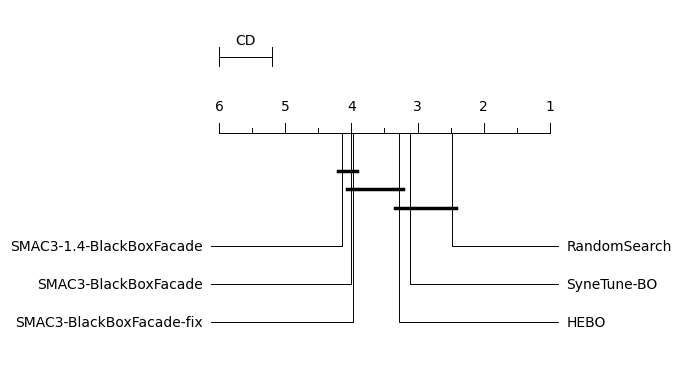

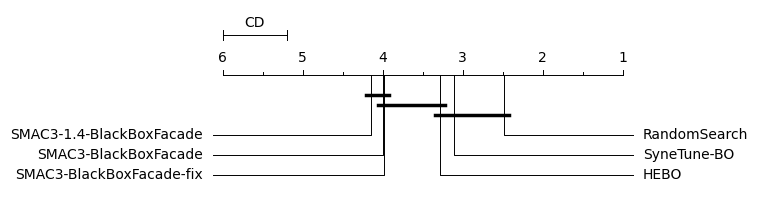

--------------------------------------------------
multi-fidelity
optimizer_id                                            DEHB  RandomSearch  \
problem_id                                                                   
hpobench/mf/real/ml/lr/10101/iter                   0.202242      0.211211   
hpobench/mf/real/ml/lr/12/iter                      0.001515      0.004545   
hpobench/mf/real/ml/lr/146212/iter                  0.034204      0.049077   
hpobench/mf/real/ml/lr/146606/iter                  0.356382      0.357580   
hpobench/mf/real/ml/lr/146818/iter                  0.115610      0.124878   
...                                                      ...           ...   
yahpo/multifidelity/so/epoch/lcbench/189906/epoch -90.975924    -88.906398   
yahpo/multifidelity/so/repl/rbv2_glmnet/375/repl   -0.960813     -0.960551   
yahpo/multifidelity/so/repl/rbv2_glmnet/458/repl   -0.997257     -0.997194   
yahpo/multifidelity/so/repl/rbv2_rpart/14/repl     -0.807332     -0.767917  

[15:04:07] INFO     Lost following experiments: optimizer_id                                     ]8;id=317583;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py\run_autorank.py]8;;\:]8;id=952835;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py#39\39]8;;\
                    DEHB  RandomSearch  \                                                                          
                    problem_id                                                                                     
                    hpobench/mf/real/ml/lr/10101/subsample              0.204036      0.211211                     
                    hpobench/mf/real/ml/lr/12/subsample                 0.004545      0.004545                     
                    hpobench/mf/real/ml/lr/146212/subsample             0.044775      0.049077                     
                    hpobench/mf/real/ml/lr/146606/subsample             0.356602      0.357580                     
                    hpobench/mf/real/ml/lr/146818/subsample             0.123415      0.124878                     
                    ...                                                      ...           ...                     
                    yahpo/multifidelity/so/trainsize/rbv2_super/15/... -0.982791     -0.982689                     
                    yahpo/multifidelity/so/trainsize/rbv2_xgboost/1... -0.985130     -0.983784                     
                    yahpo/multifidelity/so/trainsize/rbv2_xgboost/1... -0.937020     -0.931755                     
                    yahpo/multifidelity/so/trainsize/rbv2_xgboost/1... -0.977955     -0.972702                     
                    yahpo/multifidelity/so/trainsize/rbv2_xgboost/4... -0.998921     -0.997119                     
                                                                                                                   
                    optimizer_id                                                                                   
                    SMAC3-1.4-MultiFidelityFacade  \                                                               
                    problem_id                                                                                     
                    hpobench/mf/real/ml/lr/10101/subsample                                                         
                    0.208520                                                                                       
                    hpobench/mf/real/ml/lr/12/subsample                                                            
                    0.005051                                                                                       
                    hpobench/mf/real/ml/lr/146212/subsample                                                        
                    0.046082                                                                                       
                    hpobench/mf/real/ml/lr/146606/subsample                                                        
                    0.357374                                                                                       
                    hpobench/mf/real/ml/lr/146818/subsample                                                        
                    0.130244                                                                                       
                    ...                                                                                            
                    ...                                                                                            
                    yahpo/multifidelity/so/trainsize/rbv2_super/15/...                                             
                    -0.985129                                                                                      
                    y

Rejecting null hypothesis that data is normal for column DEHB (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column RandomSearch (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column SMAC3-1.4-MultiFidelityFacade (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column SMAC3-Hyperband (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column SMAC3-MultiFidelityFacade (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column SyneTune-ASHA (p=0.000000<0.007143)
Rejecting null hypothesis that data is normal for column SyneTune-DEHB (p=0.000000<0.007143)
Using Levene's test for homoscedacity of non-normal data.
Fail to reject null hypothesis that all variances are equal (p=0.999852>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test. Differences are significant,if

/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/autorank/_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/autorank/_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versi

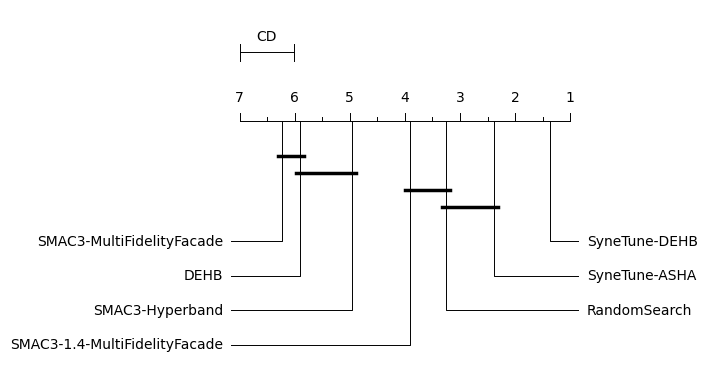

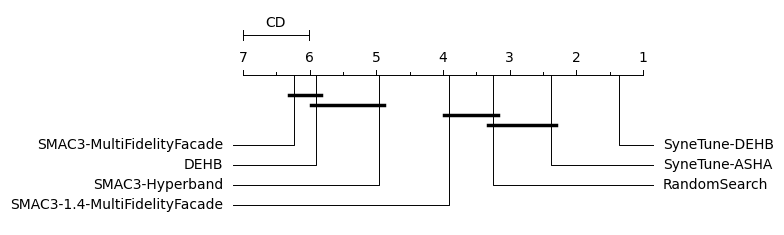

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autorank import autorank, plot_stats, create_report, latex_table
from carps.analysis.run_autorank import calc_critical_difference

scenarios = ["blackbox", "multi-fidelity"]
for scenario in scenarios:
    print("-"*50)
    print(scenario)
    result = calc_critical_difference(df[df["scenario"]==scenario], identifier=scenario)
    plot_stats(result)
    plt.show()

In [2]:
from carps.analysis.critical_difference import calc_critical_difference
scenarios = ["blackbox", "multi-fidelity"]
for scenario in scenarios:
    calc_critical_difference(df=df[df["scenario"]==scenario], identifier=scenario)


[08:47:47] INFO     Lost following experiments: optimizer_id                              ]8;id=942749;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/critical_difference.py\critical_difference.py]8;;\:]8;id=119718;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/critical_difference.py#28\28]8;;\
                    HEBO  RandomSearch  \                                                                          
                    problem_id                                                                                     
                    hpob/all/124/41                        NaN           NaN                                       
                    yahpo/so/nb301/CIFAR10/None            NaN    -94.121498                                       
                    yahpo/so/rbv2_ranger/16/None     -0.933827     -0.960873                                       
                    yahpo/so/rbv2_ranger/42/None     -0.752744     -0.986910                                       
                    yahpo/so/rbv2_super/1053/None          NaN     -0.886232                                       
                    yahpo/so/rbv2_super/1063/None          NaN     -0.915074                                       
                    yahpo/so/rbv2_super/1457/None          NaN     -0.802621                                       
                    yahpo/so/rbv2_super/1468/None          NaN     -0.973820                                       
                    yahpo/so/rbv2_super/1479/None          NaN     -0.987557                                       
                    yahpo/so/rbv2_super/15/None            NaN     -0.984062                                       
                    yahpo/so/rbv2_xgboost/12/None    -0.772316     -0.982029                                       
                    yahpo/so/rbv2_xgboost/1501/None  -0.445844     -0.922245                                       
                    yahpo/so/rbv2_xgboost/16/None    -0.120207     -0.972923                                       
                    yahpo/so/rbv2_xgboost/40499/None -0.813110     -0.997573                                       
                                                                                                                   
                    optimizer_id                      SMAC3-1.4-BlackBoxFacade  \                                  
                    problem_id                                                                                     
                    hpob/all/124/41                                        NaN                                     
                    yahpo/so/nb301/CIFAR10/None                     -94.140266                                     
                    yahpo/so/rbv2_ranger/16/None                     -0.972036                                     
                    yahpo/so/rbv2_ranger/42/None                     -0.992886                                     
                    yahpo/so/rbv2_super/1053/None                    -0.935967                                     
                    yahpo/so/rbv2_super/1063/None                    -0.905988                                     
                    yahpo/so/rbv2_super/1457/None                    -0.819553                                     
                    yahpo/so/rbv2_super/1468/None                    -0.972892                                     
                    yahpo/so/rbv2_super/1479/None                    -0.976810                                     
                    yahpo/so/rbv2_super/15/None                      -0.985433                                     
                    yahpo/so/rbv2_xgboost/12/None                    -0.988317                                     
                    yahpo/so/rbv2_xgboost/1501/None                  -0.960757                                     
       

/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


[08:47:48] INFO                                                                           ]8;id=701151;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/critical_difference.py\critical_difference.py]8;;\:]8;id=442525;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/critical_difference.py#39\39]8;;\
                    Methods: ['HEBO', 'RandomSearch', 'SMAC3-1.4-BlackBoxFacade',                                  
                    'SMAC3-BlackBoxFacade', 'SMAC3-BlackBoxFacade-fix', 'SyneTune-BO']                             
                    Average ranks: [3.61363636 4.44318182 2.66477273 3.73863636                                    
                    2.81818182 3.72159091]                                                                         
                    Groups: [array([0, 3, 5]), array([1]), array([2, 4])]                                          
                                                                                                                   

[08:47:51] INFO     Lost following experiments: optimizer_id                              ]8;id=323312;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/critical_difference.py\critical_difference.py]8;;\:]8;id=63266;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/critical_difference.py#28\28]8;;\
                    DEHB  RandomSearch  \                                                                          
                    problem_id                                                                                     
                    hpobench/mf/real/ml/lr/10101/subsample              0.204036                                   
                    0.211211                                                                                       
                    hpobench/mf/real/ml/lr/12/subsample                 0.004545                                   
                    0.004545                                                                                       
                    hpobench/mf/real/ml/lr/146212/subsample             0.044775                                   
                    0.049077                                                                                       
                    hpobench/mf/real/ml/lr/146606/subsample             0.356602                                   
                    0.357580                                                                                       
                    hpobench/mf/real/ml/lr/146818/subsample             0.123415                                   
                    0.124878                                                                                       
                    ...                                                      ...                                   
                    ...                                                                                            
                    yahpo/multifidelity/so/trainsize/rbv2_super/15/... -0.982791                                   
                    -0.982689                                                                                      
                    yahpo/multifidelity/so/trainsize/rbv2_xgboost/1... -0.985130                                   
                    -0.983784                                                                                      
                    yahpo/multifidelity/so/trainsize/rbv2_xgboost/1... -0.937020                                   
                    -0.931755                                                                                      
                    yahpo/multifidelity/so/trainsize/rbv2_xgboost/1... -0.977955                                   
                    -0.972702                                                                                      
                    yahpo/multifidelity/so/trainsize/rbv2_xgboost/4... -0.998921                                   
                    -0.997119                                                                                      
                                                                                                                   
                    optimizer_id                                                                                   
                    SMAC3-1.4-MultiFidelityFacade  \                                                               
                    problem_id                                                                                     
                    hpobench/mf/real/ml/lr/10101/subsample                                                         
                    0.208520                                                                                       
                    hpobench/mf/real/ml/lr/12/subsample                                                            
        

/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


           INFO                                                                           ]8;id=15579;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/critical_difference.py\critical_difference.py]8;;\:]8;id=765939;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/critical_difference.py#39\39]8;;\
                    Methods: ['DEHB', 'RandomSearch', 'SMAC3-1.4-MultiFidelityFacade',                             
                    'SMAC3-Hyperband', 'SMAC3-MultiFidelityFacade', 'SyneTune-ASHA',                               
                    'SyneTune-DEHB']                                                                               
                    Average ranks: [2.10240964 4.74698795 4.09036145 3.03614458                                    
                    1.77108434 5.62048193                                                                          
                     6.63253012]                                                                                   
                    Groups: [array([0]), array([1, 2]), array([3]), array([4]),                                    
                    array([5]), array([6])]                                                                        
                                                                                                                   

In [3]:

# fig, axes = plot_interval_estimates(performance_data=perf, load_from_pickle=False, figure_filename="figures/plot_interval_estimates.pdf")

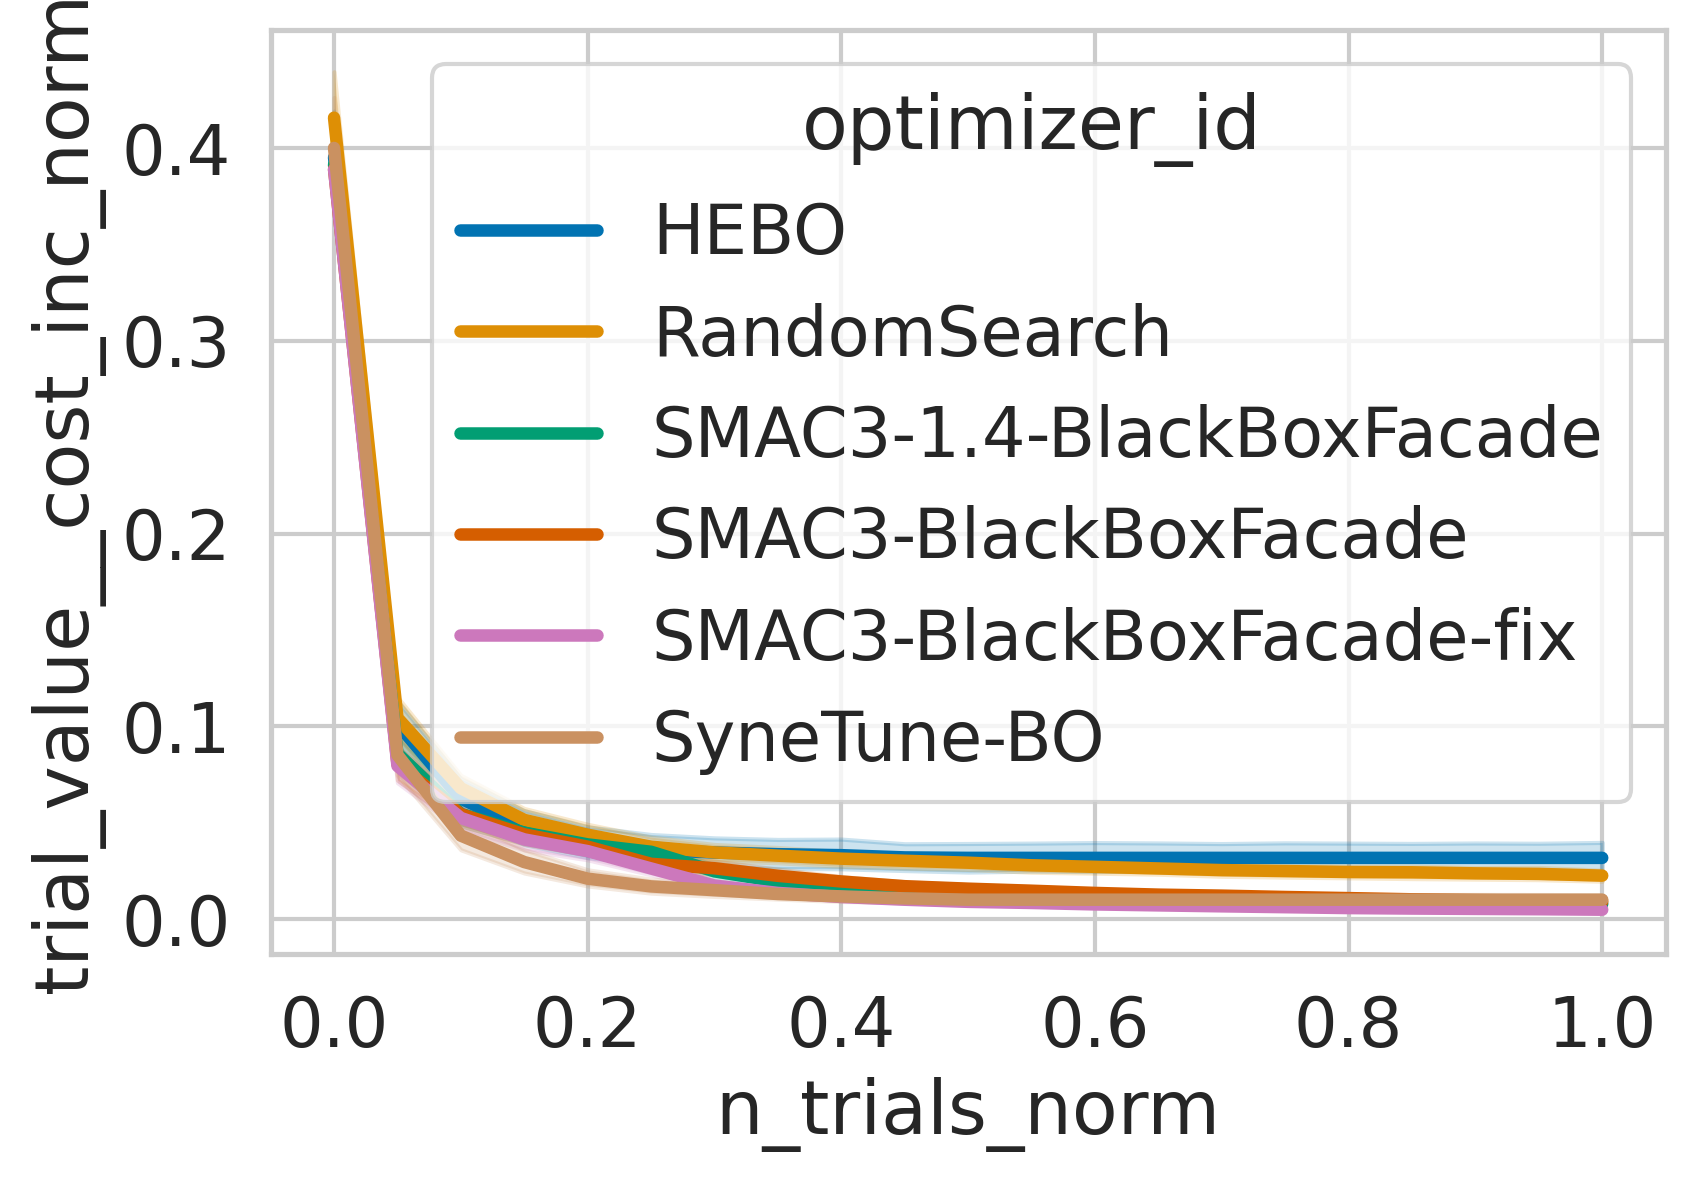

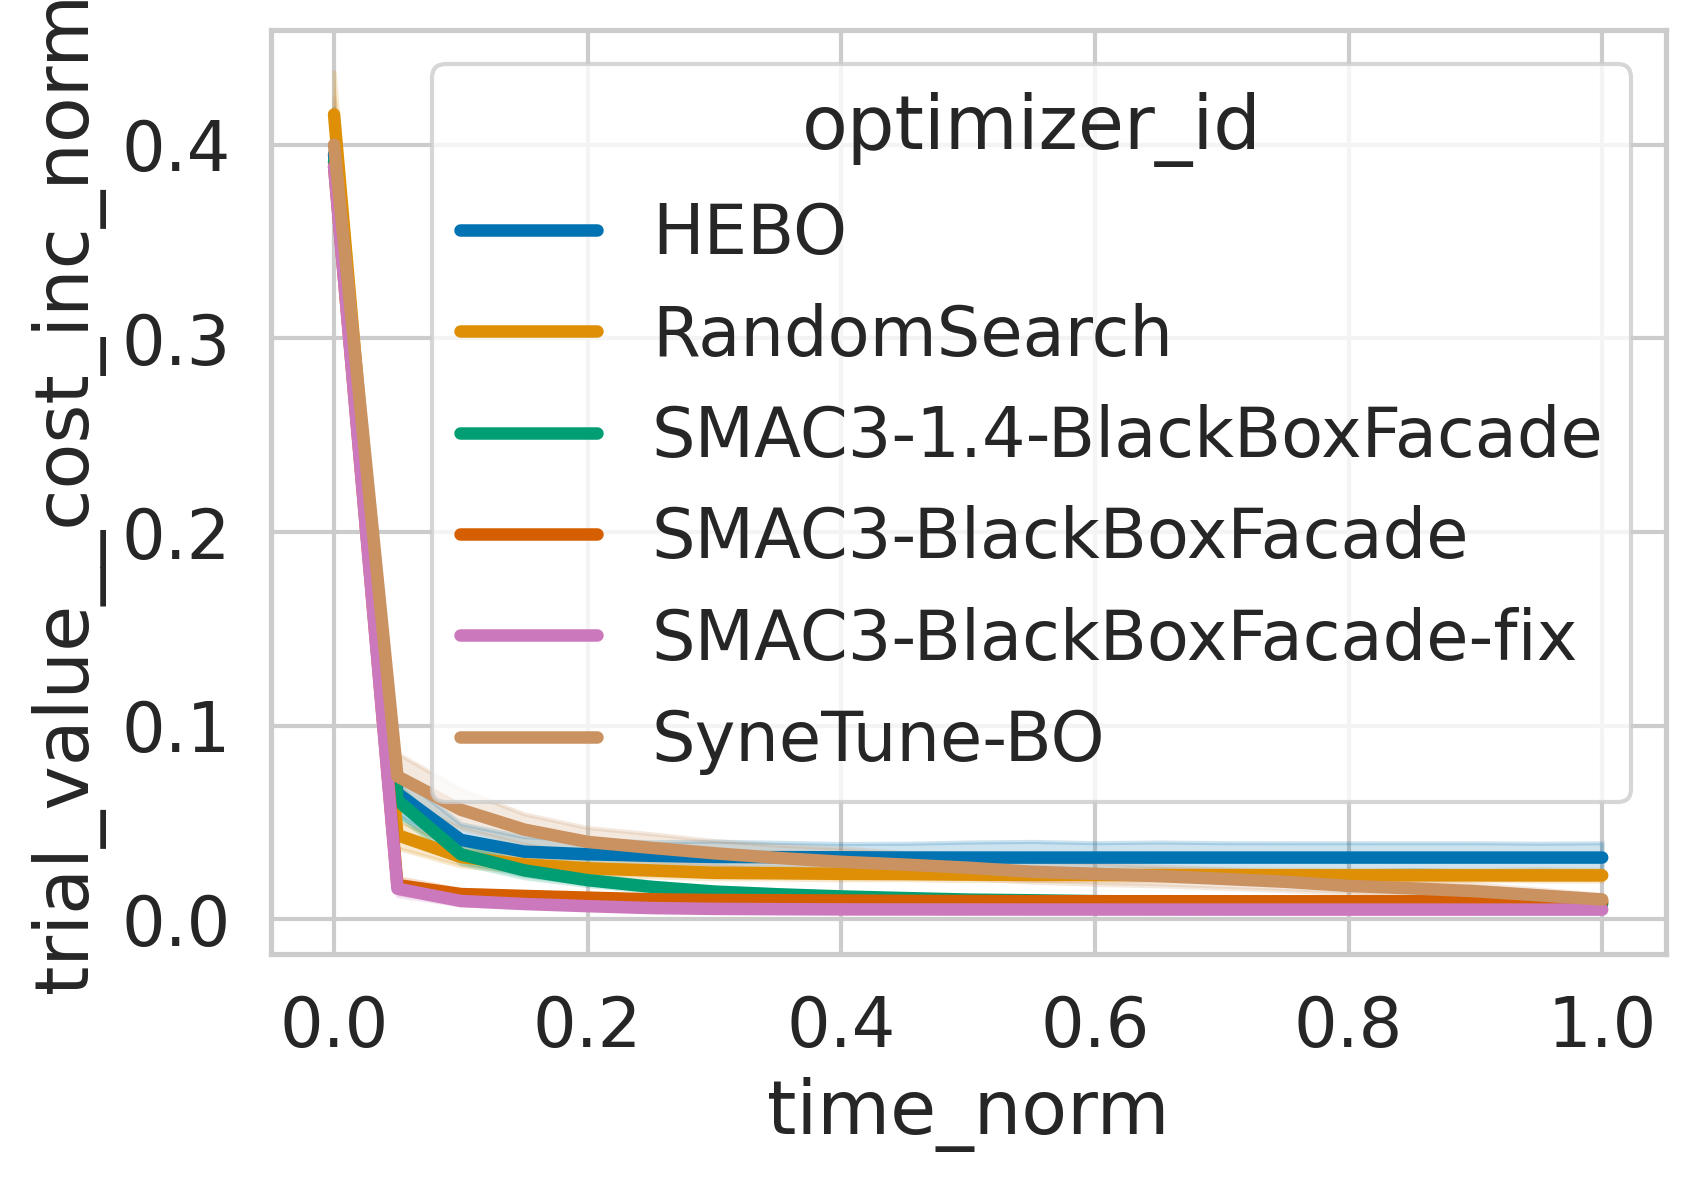

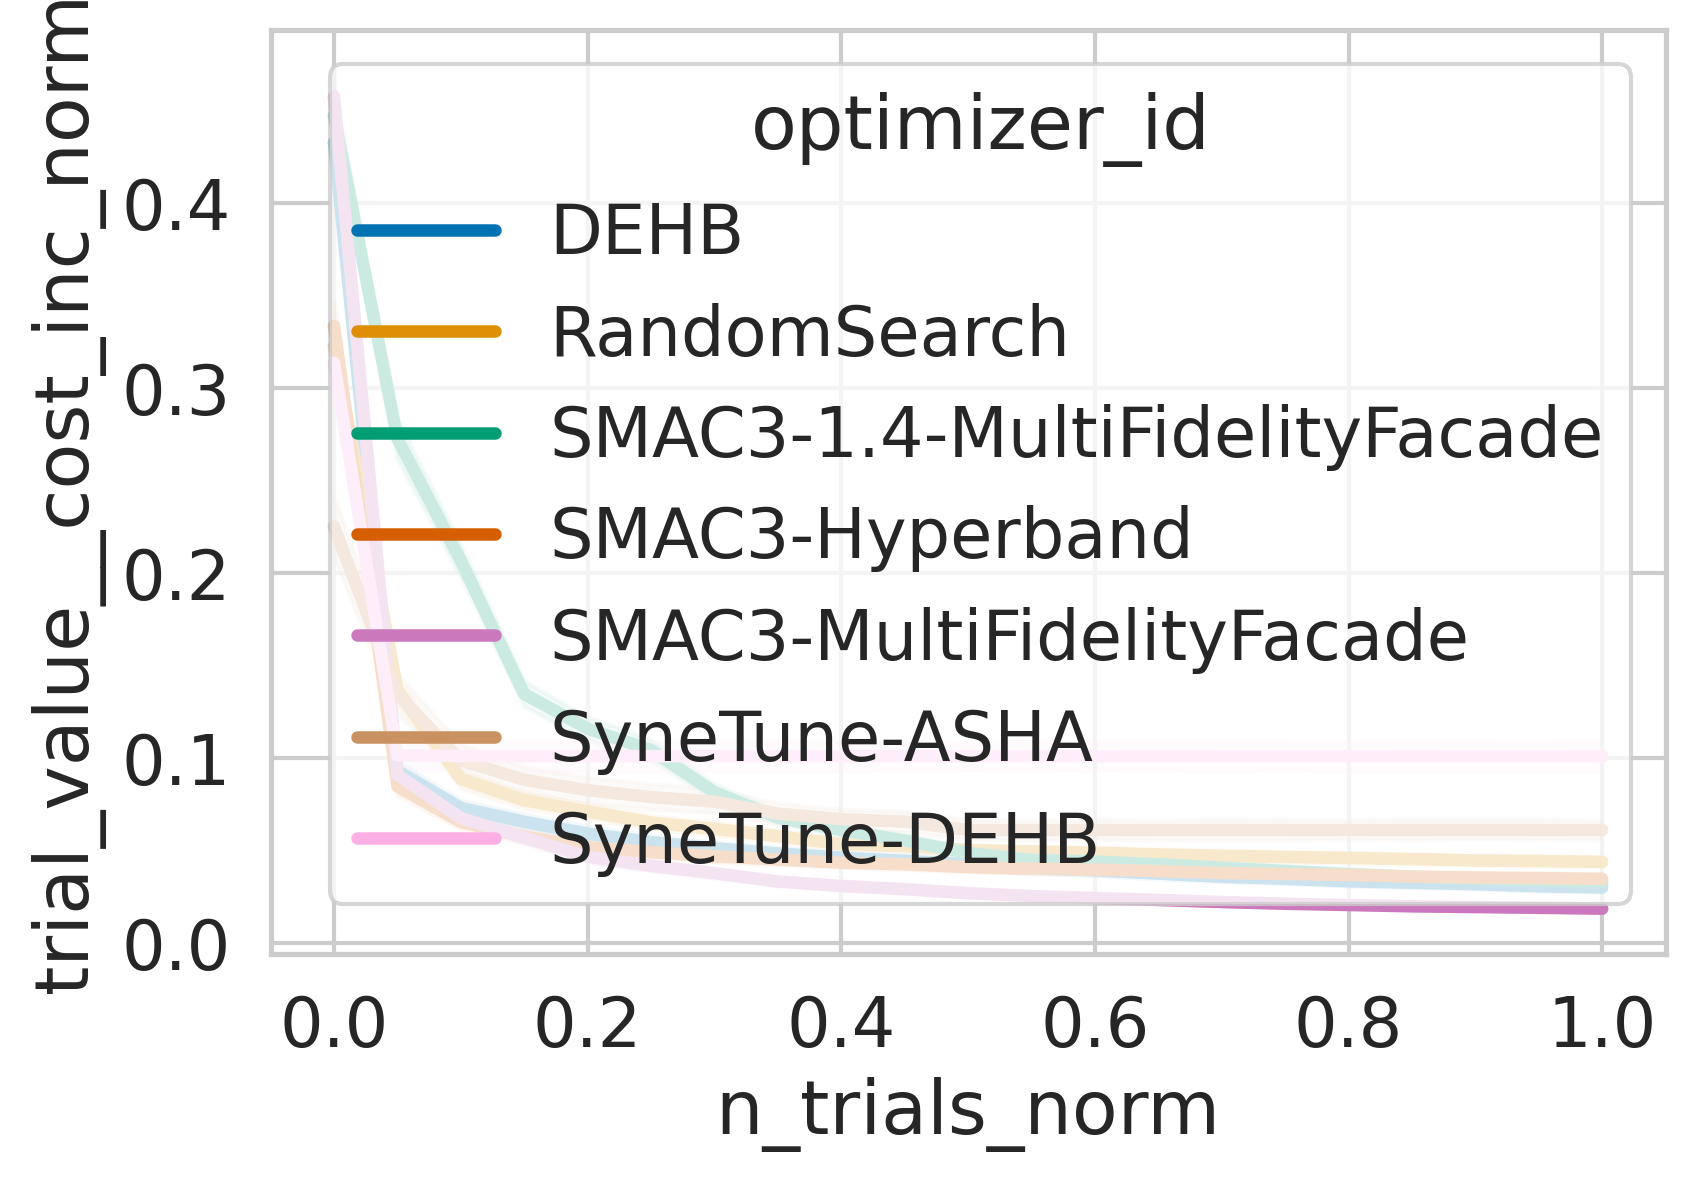

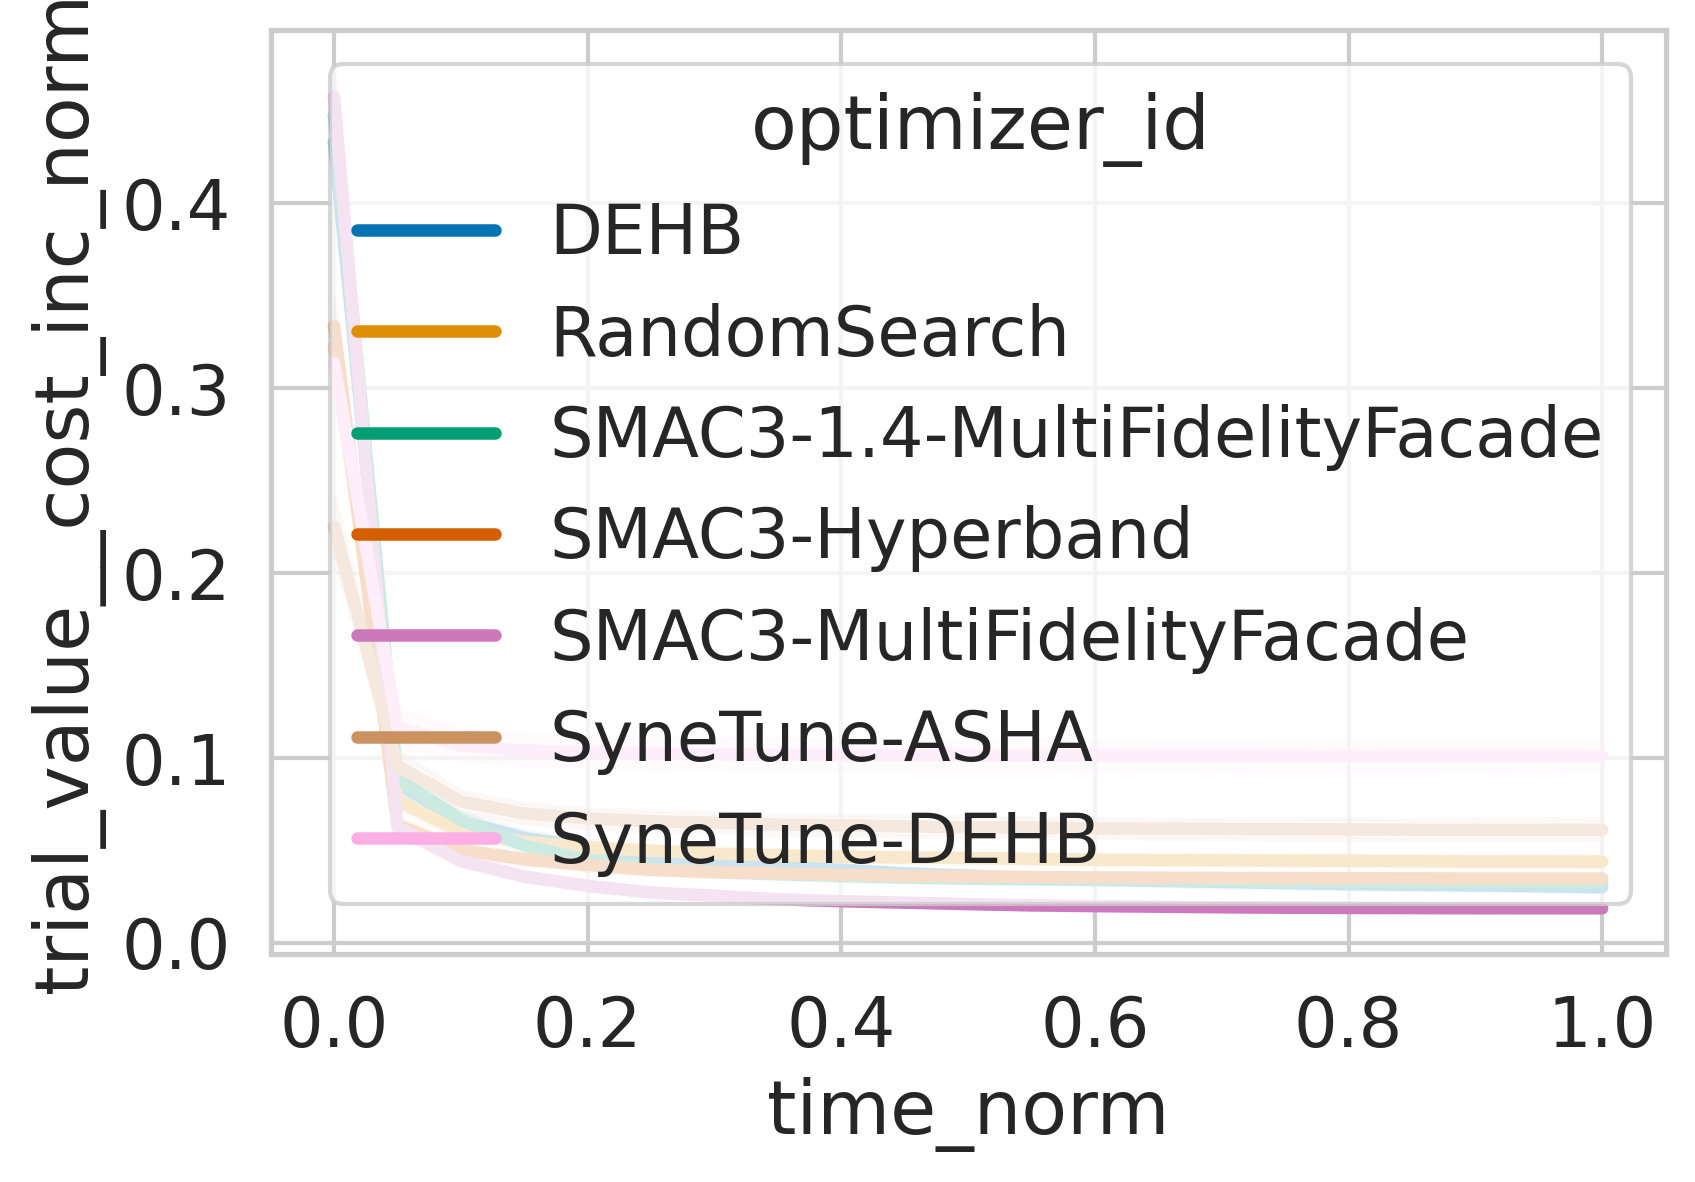

In [4]:
from carps.analysis.performance_over_time import plot_performance_over_time
lineplot_kwargs = dict(linewidth=3)
scenarios = ["blackbox", "multi-fidelity"]
for scenario in scenarios:
    fig, ax = plot_performance_over_time(
        df=perf[perf["scenario"]==scenario], 
        x="n_trials_norm", 
        y="trial_value__cost_inc_norm", 
        hue="optimizer_id", 
        figure_filename=f"figures/performance_over_time_{scenario}_trials.pdf", 
        figsize=(6,4), 
        **lineplot_kwargs
    )
    fig, ax = plot_performance_over_time(
        df=perf_time[perf_time["scenario"]==scenario], 
        x="time_norm", 
        y="trial_value__cost_inc_norm", 
        hue="optimizer_id", 
        figure_filename=f"figures/performance_over_time_{scenario}_elapsed.pdf", 
        figsize=(6,4), 
        **lineplot_kwargs
    )

In [5]:
# Plot per benchmark
from carps.analysis.utils import get_color_palette, savefig
from carps.analysis.performance_over_time import plot_performance_over_time

palette = get_color_palette(perf)
lineplot_kwargs = dict(linewidth=3)

scenarios = ["blackbox", "multi-fidelity"]

for scenario in scenarios:
    _perf = perf[perf["scenario"]==scenario]
    _perf_time = perf_time[perf_time["scenario"]==scenario]
    # Iterations
    for gid, gdf in _perf.groupby(by="benchmark_id"):    
        figure_filename = f"figures/performance_over_time_trials_{scenario}_{gid}.pdf"
        fig, ax = plot_performance_over_time(df=gdf, x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename=figure_filename, figsize=(6,4), **lineplot_kwargs)
        ax.set_title(gid)
        savefig(fig, figure_filename)
        plt.show()

    # Elapsed time
    for gid, gdf in _perf_time.groupby(by="benchmark_id"):    
        figure_filename = f"figures/performance_over_time_elapsed_{scenario}_{gid}.pdf"
        fig, ax = plot_performance_over_time(df=gdf, x="time_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename=figure_filename, figsize=(6,4), **lineplot_kwargs)
        ax.set_title(gid)
        savefig(fig, figure_filename)
        plt.show()

IndexError: list index out of range

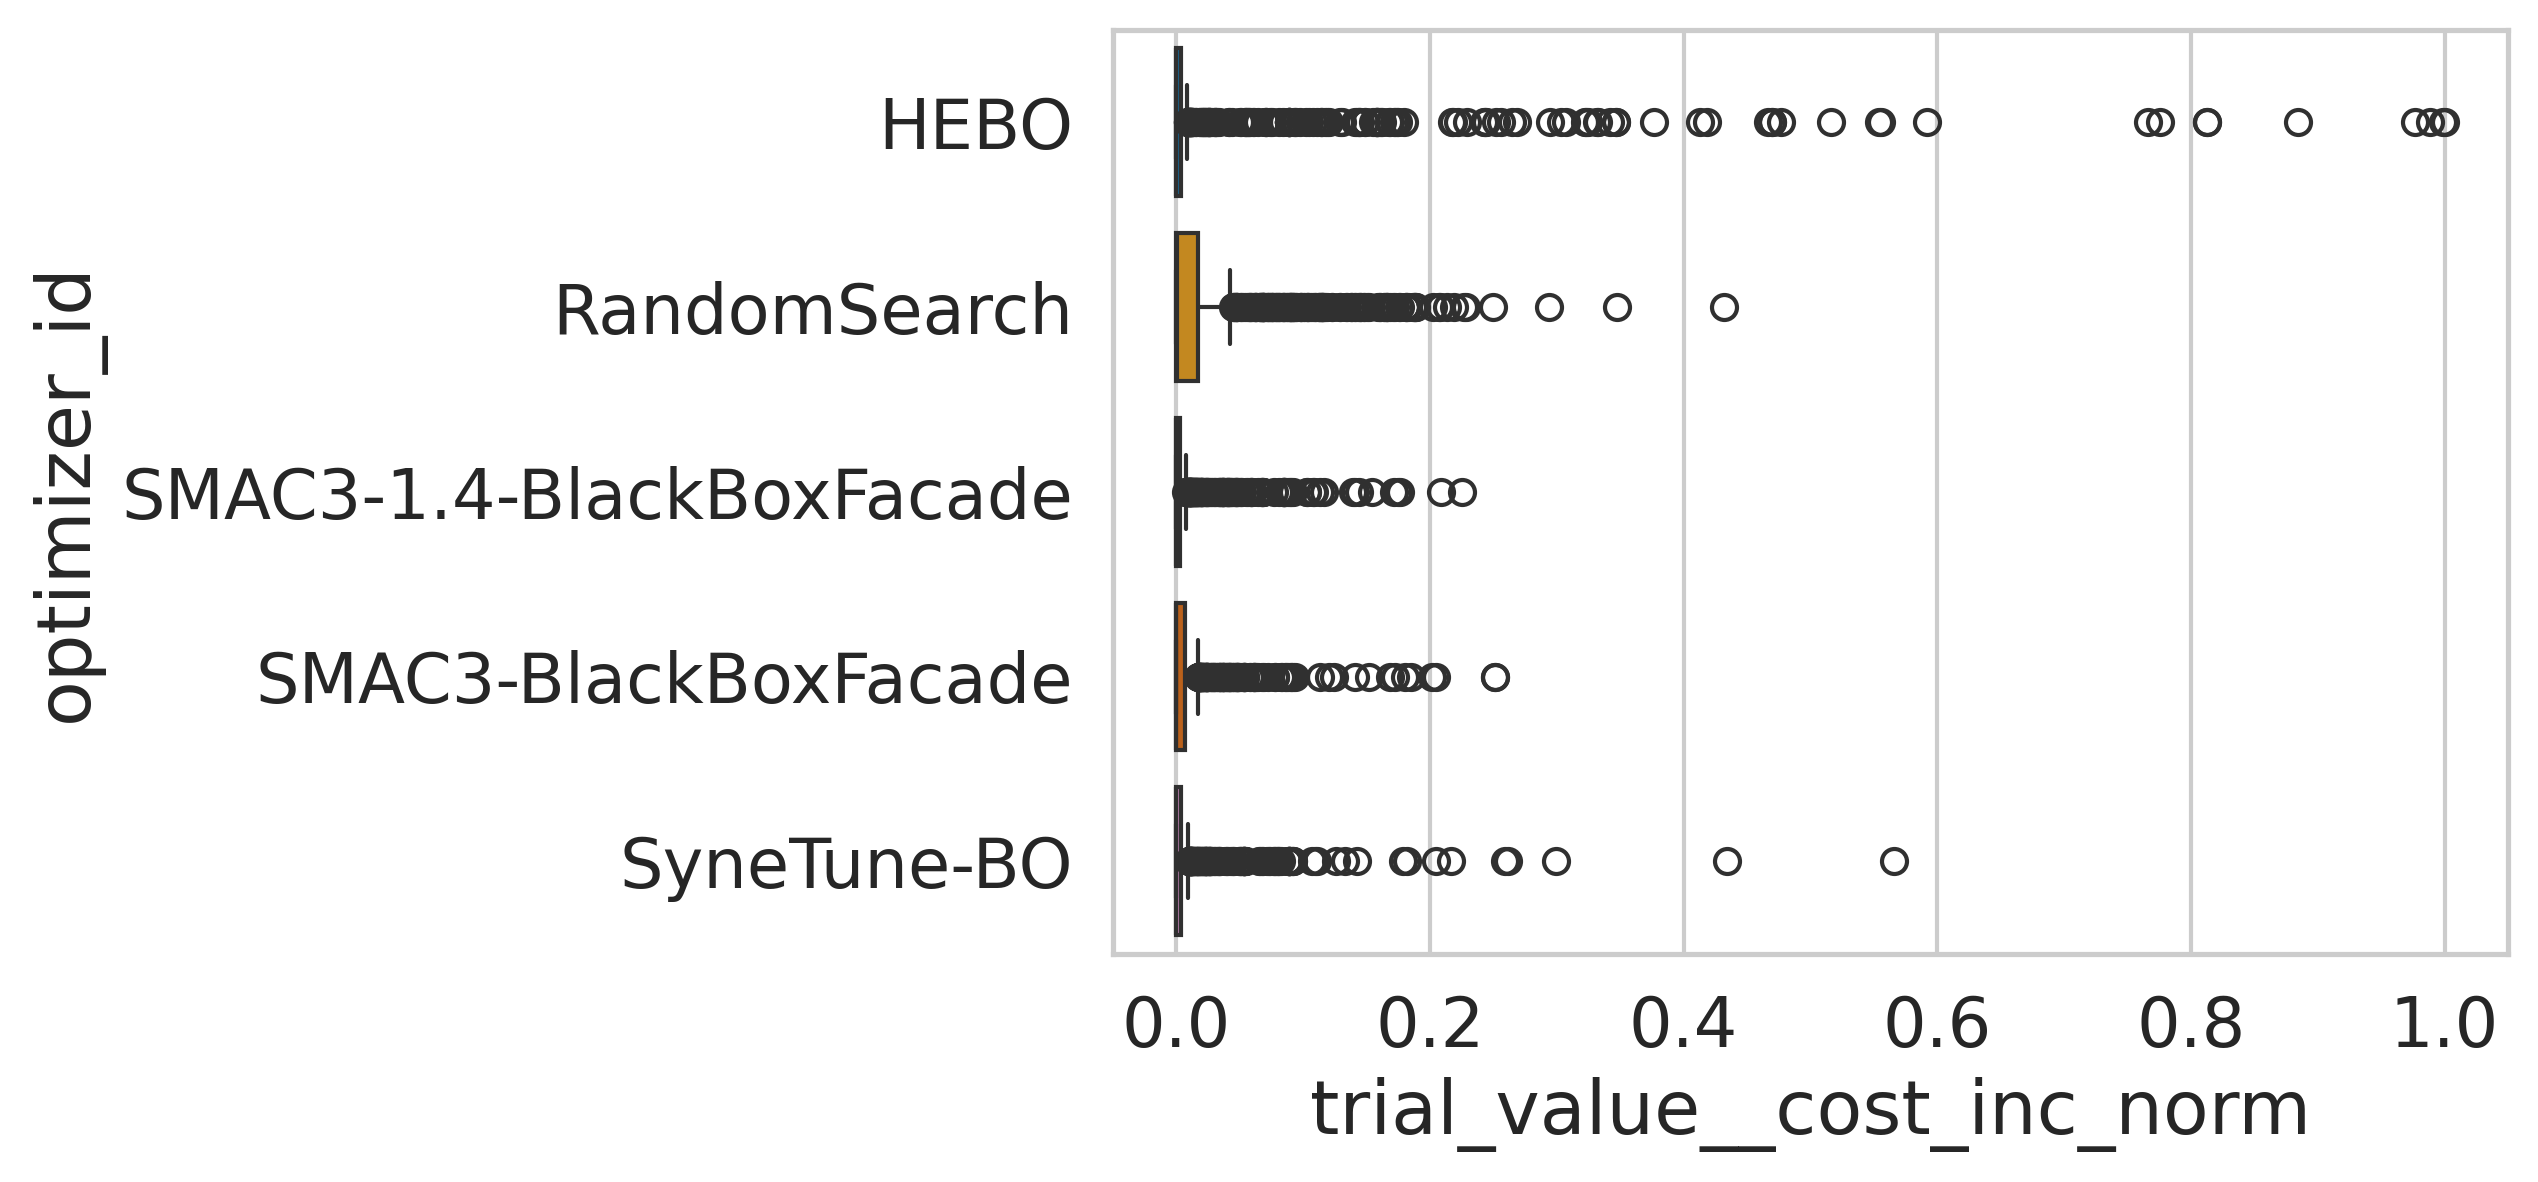

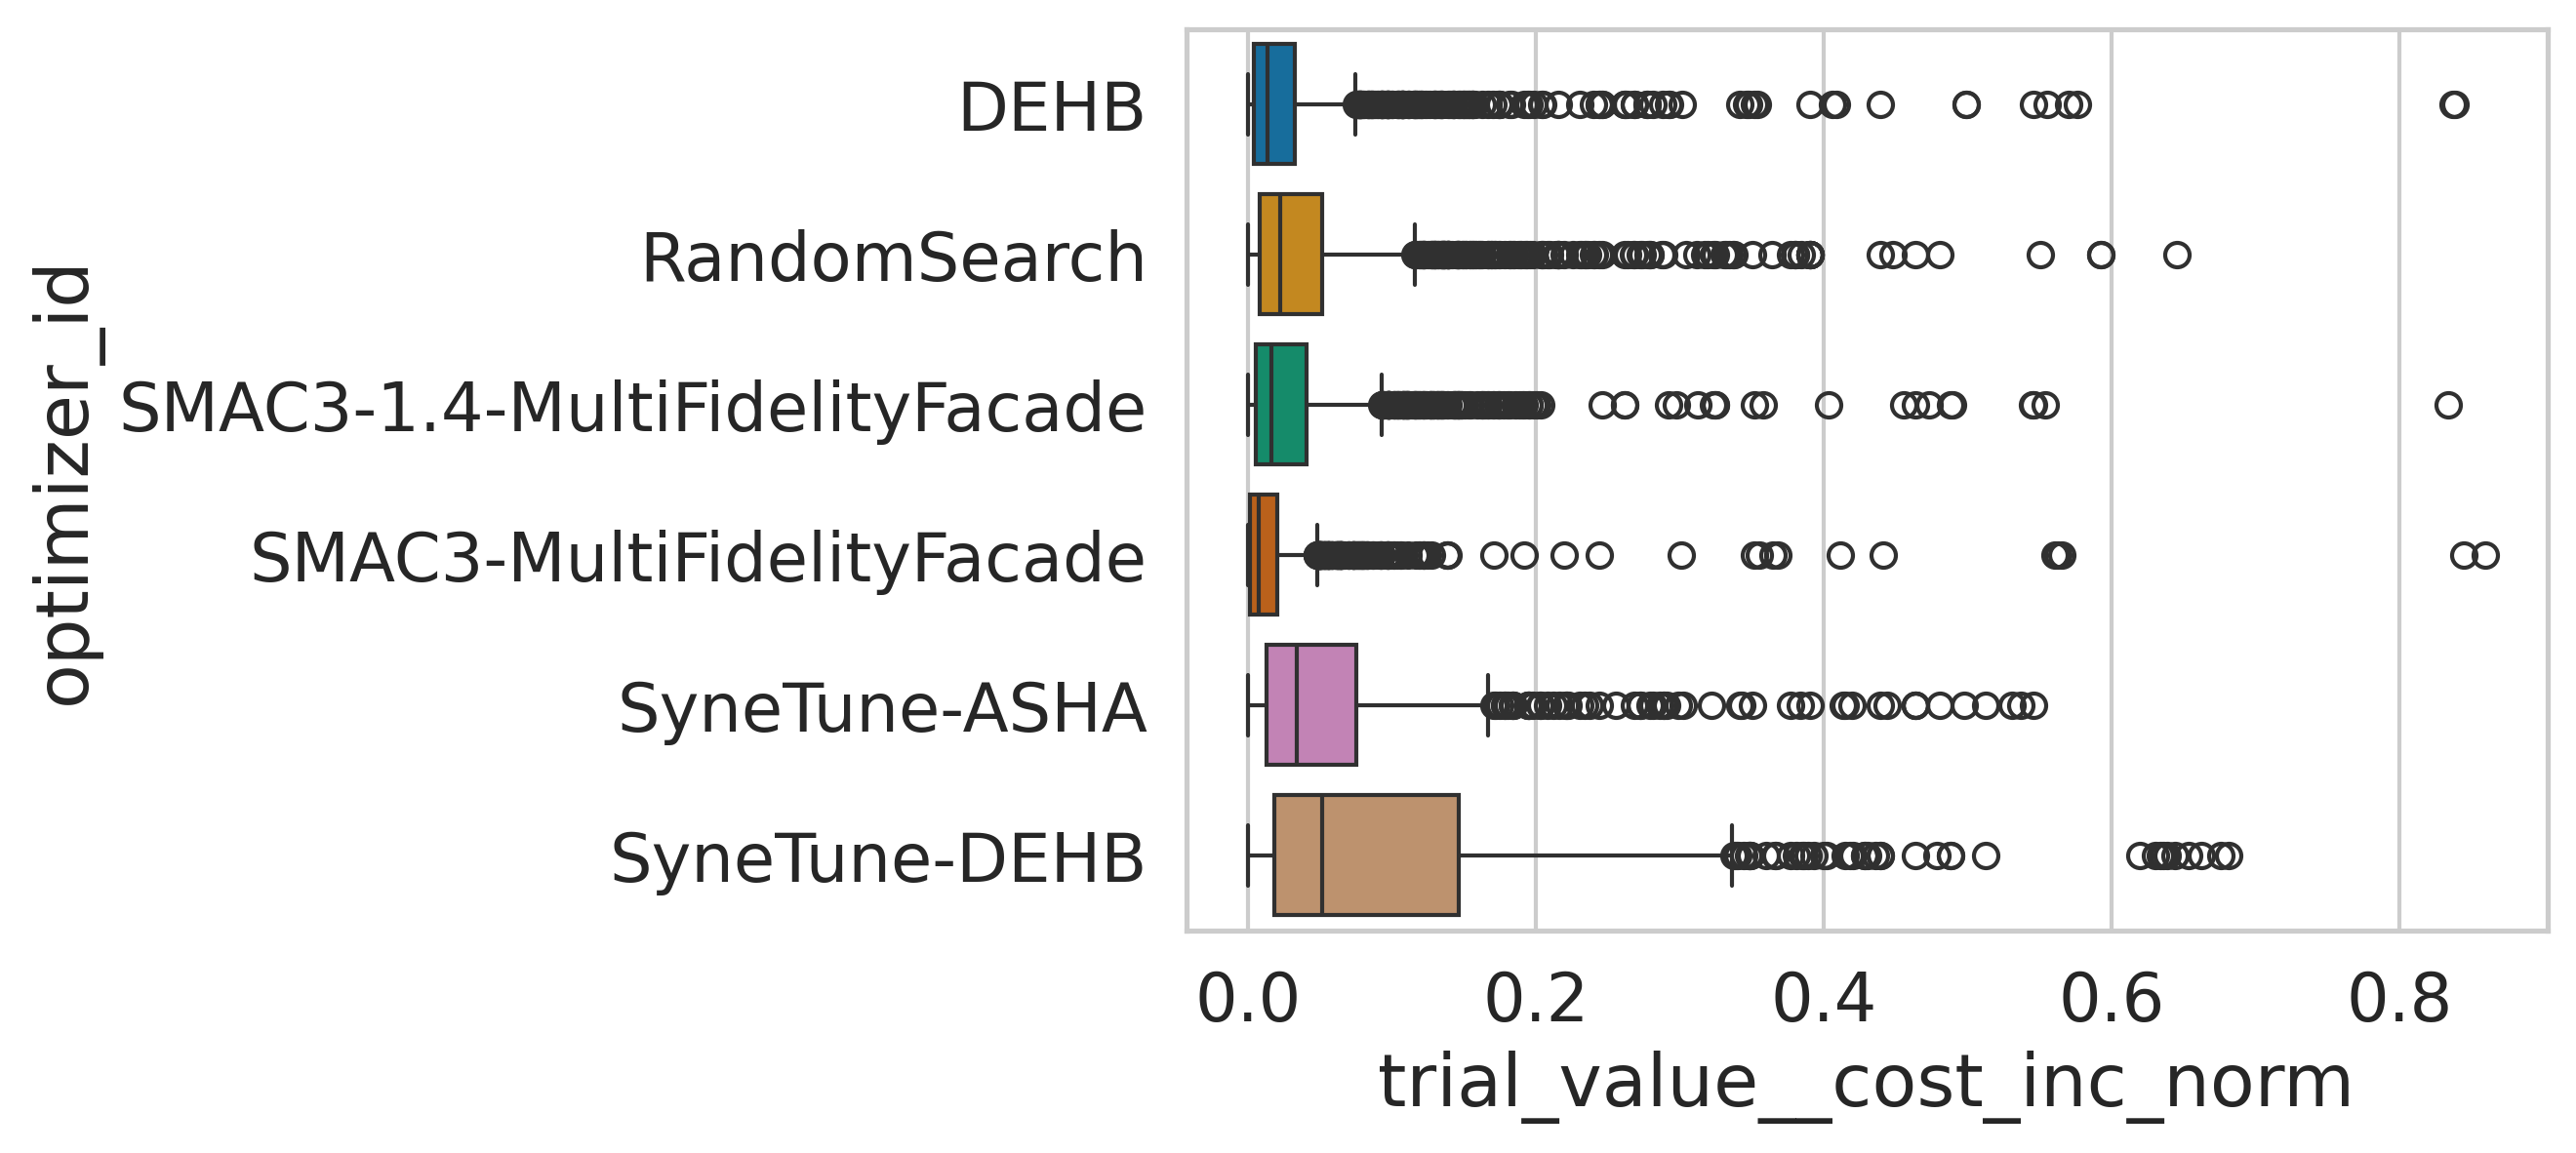

In [ ]:
from carps.analysis.final_performance import plot_final_performance_boxplot

boxplot_kwargs = dict()

scenarios = ["blackbox", "multi-fidelity"]
for scenario in scenarios:
    fig, ax = plot_final_performance_boxplot(
        df=perf[perf["scenario"]==scenario], 
        x="trial_value__cost_inc_norm", y="optimizer_id", hue="optimizer_id", figure_filename=f"figures/final_performance_boxplot_{scenario}.pdf", figsize=(6,4), **boxplot_kwargs)

In [ ]:
max_val = df["n_trials_norm"].max()
error = df.groupby(by=["benchmark_id", "problem_id", "optimizer_id", "seed"])["n_trials_norm"].apply(lambda x: not np.isclose(x.max(), max_val))
error = error[error]
for i in error.index:
    print(i)

('BBOB', 'noiseless/5/1/0', 'HEBO', 1)
('BBOB', 'noiseless/5/1/0', 'HEBO', 2)
('BBOB', 'noiseless/5/1/0', 'HEBO', 3)
('BBOB', 'noiseless/5/1/0', 'HEBO', 4)
('BBOB', 'noiseless/5/1/0', 'HEBO', 5)
('BBOB', 'noiseless/5/1/0', 'HEBO', 6)
('BBOB', 'noiseless/5/1/0', 'HEBO', 7)
('BBOB', 'noiseless/5/1/0', 'HEBO', 8)
('BBOB', 'noiseless/5/1/0', 'HEBO', 9)
('BBOB', 'noiseless/5/1/0', 'HEBO', 10)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 1)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 2)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 3)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 4)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 5)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 6)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 7)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 8)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 9)
('BBOB', 'noiseless/5/1/0', 'SyneTune-BO', 10)
('BBOB', 'noiseless/5/10/0', 'HEBO', 1)
('BBOB', 'noiseless/5/10/0', 'HEBO', 2)
('BBOB', 'noiseless/5/10/0', 'HEBO', 3)
('BBOB', 'noiseless/5/10/0',